## Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from PIL import Image
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from wordcloud import WordCloud, get_single_color_func

import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import analysis helpers

In [2]:
sys.path.insert(0, abspath('../../helpers/'))
from analysis_helpers import RECALL_WSIZE, corr_mean, format_text

Functions and variables used across multiple notebooks can be found [here](https://github.com/contextlab/sherlock-topic-model-paper/blob/master/code/helpers/analysis_helpers.py)

## Define some functions

In [3]:
def event_distinctiveness(recall_events, event):
    recall_cm = np.corrcoef(recall_events)
    

def get_event_text(event_boundaries, kind='video', sub=None):
    if kind == 'video':
        onset, offset = event_boundaries
        video_text_slice = video_text.loc[(video_text['Start Time (TRs, 1.5s)'] >= onset) 
                                          & (video_text['End Time (TRs, 1.5s)'] < offset),
                                         'Scene Details - A Level ']
        text_slice = ' '.join(video_text_slice)
    elif kind == 'recall':
        if sub is None:
            raise ValueError('must pass subject identifier if kind == "recall"')
        curr_sentences = parse_recall_sentences(event_boundaries, sub=sub)
        text_slice = '.'.join(curr_sentences) + '.'
    else:
        raise ValueError('kind must be either "video" or "recall"')
    return text_slice


def parse_recall_sentences(event_boundaries, sub):
    onset, offset = event_boundaries
    transcript_path = opj(rawdir, f'NN{sub} transcript.txt')
    with open(transcript_path, 'r', encoding='cp1252') as f:
        transcript = f.read().replace(b'\x92'.decode('cp1252'), "'").strip()

    textlist = transcript.split('.')
    windows = []
    window_n = 0
    for w_ix in range(1, RECALL_WSIZE):
        if onset <= window_n <= offset:
            start, end = 0, w_ix
            windows.append('.'.join(textlist[start : end]))
        window_n += 1
    for w_ix in range(len(textlist)):
        if onset <= window_n <= offset:
            start = w_ix
            end = w_ix + RECALL_WSIZE if w_ix + RECALL_WSIZE <= len(textlist) else len(textlist)
            windows.append('.'.join(textlist[start : end]))
        window_n += 1
    full_reclist = '.'.join(windows).split('.')
    recall_text_slice = pd.unique(full_reclist)
    return '.'.join(recall_text_slice).strip().split('.')

In [4]:
def topn(d, n):
    c = collections.Counter(d)
    return {k:v for k, v in c.most_common(n)}


def get_normalized_model(m, tm):
    m = np.dot(m, tm.components_)
    m-=m.mean(0)
    m-=np.min(m)
    m/=np.max(m)
    return m


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
    
def plot_wordle(ax, textdict, maskpath=None):
    circle = np.array(Image.open(maskpath))
    wc = WordCloud(max_font_size=50, collocations=False, max_words=200, background_color="white", mask=circle, width=2000, height=1000, colormap=plt.cm.Reds)
    wc.generate_from_frequencies(textdict)
    ax.imshow(wc.recolor(color_func=grouped_color_func, random_state=3),
           interpolation="bilinear")
    ax.axis("off")
    
    
def plot_image(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    im.image.axes=ax
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
    return artists

## Setting and parameters

In [5]:
rawdir = '../../../data/raw'
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'
sns.set_context('paper')
sns.set_style('ticks')
sns.set_palette('hls', 17)
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [6]:
video_events = np.load(opj(datadir, 'video_events.npy'), allow_pickle=True)
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)

video_event_times = np.load(opj(datadir, 'video_event_times.npy'), allow_pickle=True)
recall_event_times = np.load(opj(datadir, 'recall_event_times.npy'), allow_pickle=True)

video_text = pd.read_excel('../../../data/raw/Sherlock_Segments_1000_NN_2017.xlsx')
recall_text = np.load(opj(datadir, 'recall_text.npy'), allow_pickle=True)

matches = np.load(opj(datadir, 'labels.npy'), allow_pickle=True)

## Compute distinctiveness

In [7]:
dist_df = pd.DataFrame(index=range(len(recall_events)), columns=range(video_events.shape[0]))

for sub, rec in enumerate(recall_events):
    sub_matches = matches[sub]
    sub_cm = np.corrcoef(rec)
    sub_precs = np.diag(1 - cdist(video_events[sub_matches], rec, 'correlation'))
    for i, vid_event in enumerate(np.unique(sub_matches)):
        matched_ix = np.where(sub_matches == vid_event)[0]
        best_match = matched_ix[sub_precs[matched_ix].argmax()]
        d = 1 - corr_mean(sub_cm[best_match][sub_matches != vid_event])
        dist_df.loc[sub, vid_event] = d

In [8]:
ranked_order = dist_df.mean(axis=0).argsort()[::-1]
ranked_order += 1
dist_df.index.set_names('Participant', inplace=True)
dist_df.reset_index(inplace=True)
dist_df['Participant'] = dist_df['Participant'].apply(lambda p: f'P{p + 1}')
dist_df = dist_df.melt(id_vars=['Participant'], var_name='Video event', value_name='Distinctiveness')
dist_df['Distinctiveness'] = dist_df['Distinctiveness'].astype(np.float64)
dist_df['Video event'] += 1

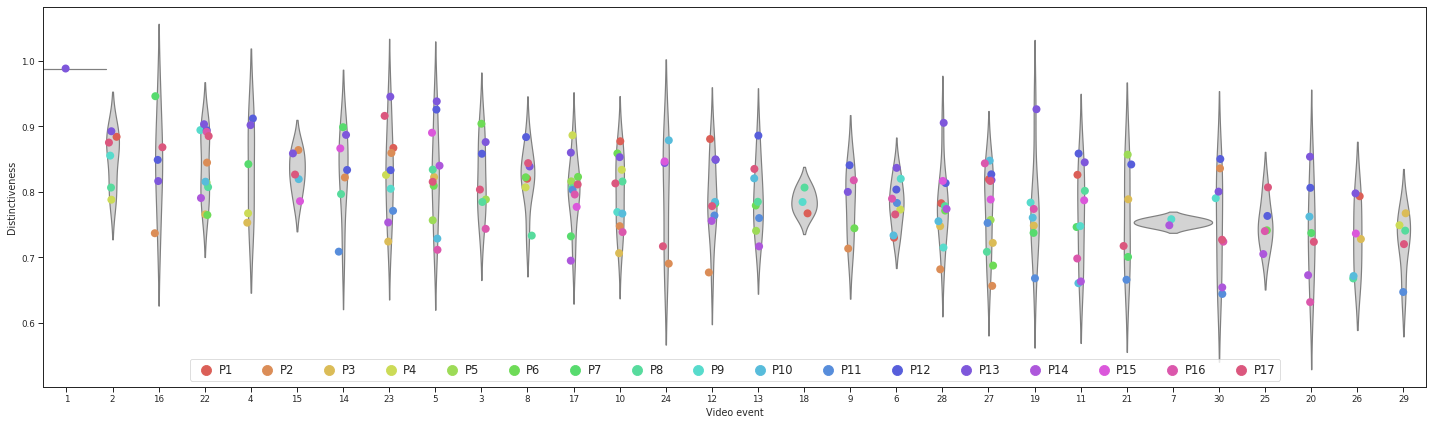

In [9]:
g = sns.catplot(x='Video event', y='Distinctiveness', data=dist_df, kind='violin',
                order=ranked_order, width=1.7, color='lightgrey', inner=None)
g.fig.set_size_inches(20, 6)
sns.stripplot(x='Video event', y='Distinctiveness', hue='Participant', data=dist_df, 
              order=ranked_order, size=8, ax=g.ax)

hs, ls = g.ax.get_legend_handles_labels()
g.ax.legend_.remove()
g.ax.legend(hs, ls, loc='lower center', ncol=17, handletextpad=.1, fontsize='large', markerscale=1.3)
for sp in g.ax.spines.values():
    sp.set_visible(True)
plt.tight_layout()
# plt.savefig(opj(figdir, 'tmp', 'distinctiveness_detail_vid_all.pdf'))
plt.show()

In [10]:
dist_ranges = dist_df.groupby('Video event')['Distinctiveness'].agg(np.ptp)
max_diff_event = dist_ranges.idxmax()
max_diff_dists = dist_df.loc[dist_df['Video event'] == max_diff_event]
high_rec = max_diff_dists.loc[max_diff_dists['Distinctiveness'].idxmax(), 'Participant']
low_rec = max_diff_dists.loc[max_diff_dists['Distinctiveness'].idxmin(), 'Participant']

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
print(f'video event: {max_diff_event}\n', 
      f'most precise: {high_rec}\n', 
      f'least precise: {low_rec}')

video event: 19
 most precise: P13
 least precise: P11


In [12]:
video_bounds = video_event_times[max_diff_event - 1]
high_rec_bounds = np.array(recall_event_times[12])[matches[12] == max_diff_event - 1][0]
low_rec_bounds = np.array(recall_event_times[10])[matches[10] == max_diff_event - 1][0]

In [13]:
video_event_text = get_event_text(video_bounds, kind='video')
high_rec_text = get_event_text(high_rec_bounds, kind='recall', sub=13)
low_rec_text = get_event_text(low_rec_bounds, kind='recall', sub=11)

In [14]:
video_event_text

'John looks at Sherlock in shock as Sherlock gets up and continues: "…so what or rather whom does she remove her rings for?" Sherlock: "Clearly not one lover; she\'d never sustain the fiction of being single over that amount of time, so more likely a string of them. Simple." John admiringly says to Sherlock: "That\'s brilliant." Sherlock looks round at him and John immediately says: "Sorry."  Lestrade asks: "Cardiff?" Sherlock says: "It\'s obvious, isn\'t it?" John: "It\'s not obvious to me." and stares at Sherlock.  Sherlock pauses as he looks at the other two men and says seriously: "Dear God, what is it like in your funny little brains? It must be so boring." Sherlock turns back to the body and explains in a lively manner: "Her coat: it\'s slightly damp. She\'s been in heavy rain in the last few hours. No rain anywhere in London in that time." Sherlock continues, looking at Lestrade: "Under her coat collar is damp, too. She\'s turned it up against the wind. She\'s got an umbrella in

In [15]:
high_rec_text

"And Sherlock is like its the same poison as before, its the poison from the serial suicides. And then there's a conversation about the facts that Sherlock has discovered. Okay late 30s, serial adulterer, had a lot of lovers, unhappily married for the last 10 years, you can see that her wedding ring is dirty, all her other jewelry is clean, but the inside is more clean than the outside which means that only polishing??? regularly. She needed to have a bunch of string of lovers because its hard to pretend to be single for a long time, a number of boyfriends, knew that she was married. She probably worked, she was a businesswoman judging by the attire, media probably judging by the suit color. She was in the rain because her jacket was wet, it was also really windy, because well so this is the response, her outfit is a response to the Sergeant's surprise when the guy says she was from this specific town and she only wanted to stay overnight. He's like how do you know this? Well the coat 

In [16]:
low_rec_text

"He also notices that her jewelry is new, her coat is wet. And so he diagnoses that she is from out of town because her coat is still wet. And she has an umbrella but she didn't use it which means that it was windy. So its about like a two hour, two hours out of town or something. And so he figures out where she is from. So he tells all this to inspector. And the inspector kind of just, he's excited that Sherlock has figured this out. And then Sherlock says that this person has made a mistake, like the murderer has made a mistake. And when Watson asks him why, he says its because she's in pink. And he means that she had a suitcase, because he notices that on the back of her stockings there were splash marks indicating that she was pulling along a suitcase. And Watson helped by saying that she died through asphyxiation, possibly choking on her own vomit. So that way he came into--he was handy. And then so Sherlock runs out and Watson comes behind and asks the inspector where Sherlock we

In [17]:
# p13_event_words = np.unique(format_text(high_rec_text).replace('.', '').split())
# p13_event_words = [w for w in p13_event_words if w not in stop_words]

# p13_other_words = ''
# for bounds in recall_event_times[12]:
#     if bounds == tuple(high_rec_bounds):
#         continue
#     event_text = get_event_text(bounds, kind='recall', sub=13)
#     p13_other_words += ' ' + event_text
    
# p13_other_words = format_text(p13_other_words).replace('.', '').split()
# p13_other_words = [w for w in p13_other_words if w not in stop_words]
# p13_other_words, p13_counts = np.unique(p13_other_words, return_counts=True)
# p13_dict = {w: c for w, c in zip(p13_other_words, p13_counts)}
# p13_event_dict = {w: 1 - (p13_dict[w] / p13_counts.max()) for w in p13_event_words}

In [18]:
# p13_event_words = np.unique(format_text(high_rec_text).replace('.', '').split())
# p13_event_words = {w : 0 for w in p13_event_words if w not in stop_words}

# for bounds in recall_event_times[12]:
# #     if bounds == tuple(high_rec_bounds):
# #         continue
#     event_text = get_event_text(bounds, kind='recall', sub=13)
#     event_text_fmt = format_text(event_text).replace('.', '').split()
#     event_text_nostop = [w for w in event_text_fmt if w not in stop_words]
#     for w in p13_event_words:
#         if w in event_text_nostop:
#             p13_event_words[w] += 1
            
# p13_counts = list(p13_event_words.values())
# p13_event_dict = {w: 1 / p13_event_words[w] for w in p13_event_words}

# # cutoff = np.sort(list(p13_event_dict.values()))[-75]

# # p13_event_dict = {w: v for w, v in p13_event_dict.items() if v <= cutoff}

In [19]:
# p13_event_words = format_text(high_rec_text).replace('.', '').split()
# p13_event_wc = {w: p13_event_words.count(w) for w in p13_event_words if w not in stop_words}

# p13_other_wc = {w: 0 for w in p13_event_wc}
# for bounds in recall_event_times[12]:
# #     if bounds == tuple(high_rec_bounds):
# #         continue
#     event_text = get_event_text(bounds, kind='recall', sub=13)
#     event_text_fmt = format_text(event_text).replace('.', '').split()
#     event_text_nostop = [w for w in event_text_fmt if w not in stop_words]
#     for w in p13_other_wc.keys():
#         p13_other_wc[w] += event_text_nostop.count(w)

# p13_event_dict = {w: p13_event_wc[w] / p13_other_wc[w] for w in p13_event_wc.keys()}

# # cutoff = np.sort(list(p13_event_dict.values()))[-50]
# # p13_event_dict = {w: v for w, v in p13_event_dict.items() if v >= cutoff}

In [20]:
# p11_event_words = np.unique(format_text(low_rec_text).replace('.', '').split())
# p11_event_words = [w for w in p11_event_words if w not in stop_words]

# p11_other_words = ''
# for bounds in recall_event_times[10]:
#     if bounds == tuple(low_rec_bounds):
#         continue
#     event_text = get_event_text(bounds, kind='recall', sub=11)
#     p11_other_words += ' ' + event_text
    
# p11_other_words = format_text(p11_other_words).replace('.', '').split()
# p11_other_words = [w for w in p11_other_words if w not in stop_words]
# p11_other_words, p11_counts = np.unique(p11_other_words, return_counts=True)
# p11_dict = {w: c for w, c in zip(p11_other_words, p11_counts)}
# p11_event_dict = {w: 1 - (p11_dict[w] / p11_counts.max()) for w in p11_event_words}

In [21]:
# p11_event_words = np.unique(format_text(low_rec_text).replace('.', '').split())
# p11_event_words = {w : 0 for w in p11_event_words if w not in stop_words}

# for bounds in recall_event_times[10]:
# #     if bounds == tuple(low_rec_bounds):
# #         continue
#     event_text = get_event_text(bounds, kind='recall', sub=11)
#     event_text_fmt = format_text(event_text).replace('.', '').split()
#     event_text_nostop = [w for w in event_text_fmt if w not in stop_words]
#     for w in p11_event_words:
#         if w in event_text_nostop:
#             p11_event_words[w] += 1
            
# p11_counts = list(p11_event_words.values())
# p11_event_dict = {w: 1 / p11_event_words[w] for w in p11_event_words}

In [22]:
# p11_event_words = format_text(low_rec_text).replace('.', '').split()
# p11_event_wc = {w: p11_event_words.count(w) for w in p11_event_words if w not in stop_words}

# p11_other_wc = {w: 0 for w in p11_event_wc}
# for bounds in recall_event_times[10]:
# #     if bounds == tuple(high_rec_bounds):
# #         continue
#     event_text = get_event_text(bounds, kind='recall', sub=11)
#     event_text_fmt = format_text(event_text).replace('.', '').split()
#     event_text_nostop = [w for w in event_text_fmt if w not in stop_words]
#     for w in p11_other_wc.keys():
#         p11_other_wc[w] += event_text_nostop.count(w)

# p11_event_dict = {w: p11_event_wc[w] / p11_other_wc[w] for w in p11_event_wc.keys()}

# # cutoff = np.sort(list(p11_event_dict.values()))[-50]
# # p11_event_dict = {w: v for w, v in p11_event_dict.items() if v >= cutoff}

In [23]:
# fig, ax = plt.subplots(1)

# color_to_words = {c: [] for c in ['red', 'blue']}#, 'green', 'violet', 'indigo']}
# for word, count in p13_event_dict.items():
#     if count == .5:
#         color_to_words['red'].append(word)
# #     elif count > .3:
# #         color_to_words['blue'].append(word)
# #     elif count > .2:
# #         color_to_words['green'].append(word)
# #     elif count > .1:
# #         color_to_words['violet'].append(word)
#     else:
#         color_to_words['blue'].append(word)


# # color_to_words = {'black': list(set(p13_event_dict))}
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, 'grey')
# plot_wordle(ax, p13_event_dict, grouped_color_func, maskpath=opj(datadir, "oval2.jpg"))

In [24]:
# fig, ax = plt.subplots(1)

# color_to_words = {c: [] for c in ['red', 'blue']}#, 'green', 'lightblue', 'lightgreen']}
# for word, count in p11_event_dict.items():
#     if count == .5:
#         color_to_words['red'].append(word)
# #     elif count > .3:
# #         color_to_words['blue'].append(word)
# #     elif count > .2:
# #         color_to_words['green'].append(word)
# #     elif count > .1:
# #         color_to_words['lightblue'].append(word)
#     else:
#         color_to_words['blue'].append(word)
        
        
# # color_to_words = {'black': list(set(p11_event_dict))}
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, 'grey')
# plot_wordle(ax, p11_event_dict, grouped_color_func, maskpath=opj(datadir, "oval2.jpg"))

In [25]:
# def plot_wordle(ax, textdict, color_dict, maskpath=None):
#     circle = np.array(Image.open(maskpath))
#     wc = WordCloud(max_font_size=100, relative_scaling=0, collocations=False, max_words=200, min_font_size=1,
#                    background_color="white", mask=None, height=800, width=1200, colormap=plt.cm.Reds, font_step=5)
#     wc.generate_from_frequencies(textdict)
#     ax.imshow(wc.recolor(color_func=color_dict, random_state=3),
#            interpolation="bilinear")
#     ax.axis("off")

In [26]:
# plt.hist(list(p11_event_dict.values()), bins=30, range=(0,.5))
# plt.ylim(0, 40)

In [27]:
# plt.hist(list(p13_event_dict.values()), bins=30, range=(0, .5))
# plt.ylim(0, 40)